# 01. Import Libraries

In [1]:
pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl 

In [3]:
# Prompt matplotlib visuals to appear in the notebook 
%matplotlib inline

# 02. Import Data

In [4]:
path = r"C:\Users\esteb\OneDrive\Desktop\2025_Credit Card Transaction Analysis"

In [5]:
df = pd.read_pickle(os.path.join(path, '02_Data', 'Prepared Data', 'cc_combined_transactions.pkl'))

# 03. Data Wrangling

In [6]:
df.shape

(24386833, 52)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386833 entries, 0 to 24386832
Data columns (total 52 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   user_id                     int64         
 1   card_index                  int64         
 2   txn_year                    int64         
 3   txn_month                   int64         
 4   txn_day                     int64         
 5   txn_date                    datetime64[ns]
 6   txn_time                    object        
 7   txn_amount                  float64       
 8   txn_flag                    object        
 9   txn_type                    object        
 10  merchant_name               int64         
 11  merchant_city               object        
 12  merchant_state              object        
 13  merchant_country            object        
 14  txn_zip_code                Int64         
 15  MCC                         int64         
 16  errors?         

In [8]:
# Remove unnecessary columns (categorical, datetime, text, and ID-like columns)
df = df.drop(columns = [
    'card_index',
    'txn_time',
    'txn_flag',
    'txn_type',
    'merchant_name',
    'merchant_city',
    'merchant_state',
    'merchant_country',
    'txn_zip_code',
    'MCC',
    'user_name',
    'gender',
    'address',
    'apartment',
    'city',
    'state',
    'user_zip_code',
    'Income_category',
    'card_brand',
    'card_type',
    'card_number',
    'expires',
    'CVV',
    'has_chip',
    'card_on_dark_web',
    'Credit Limit Category',
    'Age Group',
    'Income Bracket',
    'Amount Category',
    'txn_date',
    'birth_year',
    'birth_month',
    'acct_open_date',
    'year_PIN_last_changed',
    'cards_issued',
    'num_credit_cards',
    'errors?',
    'is_fraud?'], errors='ignore')

In [9]:
# View Columns
df.columns

Index(['user_id', 'txn_year', 'txn_month', 'txn_day', 'txn_amount',
       'current_age', 'retirement_age', 'latitude', 'longitude',
       'per_capita_income_zip_code', 'yearly_income_person', 'total_debt',
       'FICO_score', 'credit_limit'],
      dtype='object')

# 04. Elbow Technique

### Full Dataframe

In [10]:
num_cl = range(1, 10) # Defines the range of potential clusters in the data.
kmeans = [KMeans(n_clusters=i) for i in num_cl] # Defines k-means clusters in the range assigned above.

In [11]:
# Creates a score that represents a rate of variation for the given cluster option.
score = [kmeans[i].fit(df).score(df) for i in range(len(kmeans))]

score

[-8.899969796477206e+16,
 -4.668935977200885e+16,
 -3.1969885168094384e+16,
 -2.4843222874509744e+16,
 -2.1265575675157108e+16,
 -1.7670172428561494e+16,
 -1.6263250298555032e+16,
 -1.3120904224187374e+16,
 -1.2259850656128244e+16]

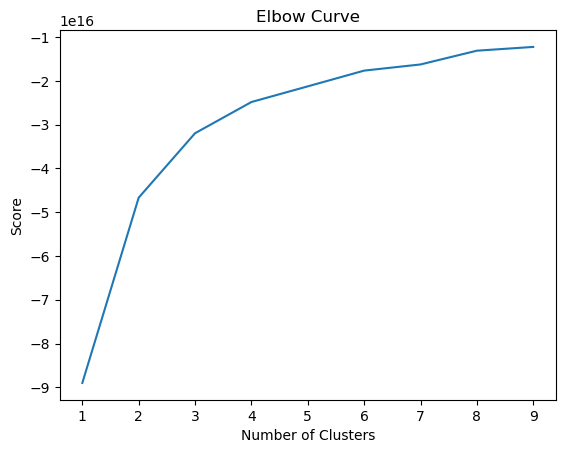

In [12]:
# Plot the elbow curve using PyLab.

pl.plot(num_cl,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

The optimal number of clusters seems to be 4.

### Aggragate by User Dataframe

In [13]:
df_user_txn = df.groupby('user_id').agg({
    'txn_amount': ['mean', 'sum', 'count'],
    'yearly_income_person': 'first'
}).reset_index()
df_user_txn.columns = ['user_id', 'avg_txn', 'total_txn', 'txn_count', 'yearly_income_person']

In [14]:
num_cl_txn = range(1, 10)
kmeans_txn = [KMeans(n_clusters=i, random_state=42) for i in num_cl_txn]

In [15]:
score_2 = [kmeans_txn[i].fit(df_user_txn[['avg_txn', 'total_txn', 'txn_count', 'yearly_income_person']]).score(
            df_user_txn[['avg_txn', 'total_txn', 'txn_count', 'yearly_income_person']])
               for i in range(len(kmeans_txn))]

score_2

[-542123305512931.56,
 -214811439175338.4,
 -115826768771238.84,
 -65396872257221.0,
 -44088609630569.21,
 -32358291645070.02,
 -22218993349625.84,
 -17325569216526.959,
 -13225478162199.426]

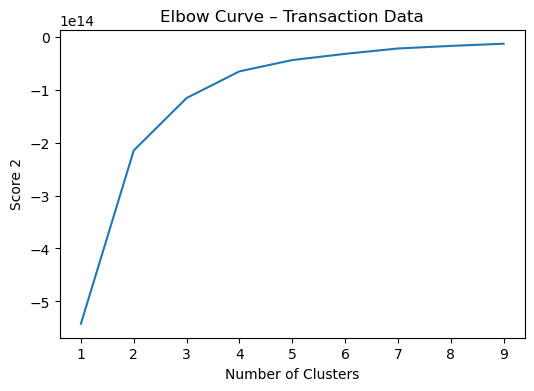

In [16]:
# Plot the elbow curve using PyLab.
pl.figure(figsize=(6,4))
pl.plot(num_cl_txn, score_2)
pl.title('Elbow Curve – Transaction Data')
pl.xlabel('Number of Clusters')
pl.ylabel('Score 2')
pl.show()

The optimal number of clusters seems to be 4.

# 05. K-means Clustering

### Full Dataframe

In [17]:
# Create the k-means object.
kmeans = KMeans(n_clusters = 4)

In [18]:
# Fit the k-means object to the data.
kmeans.fit(df)

KMeans(n_clusters=4)

In [19]:
df['clusters'] = kmeans.fit_predict(df)

In [20]:
df.head()

,user_id,txn_year,txn_month,txn_day,txn_amount,current_age,retirement_age,latitude,longitude,per_capita_income_zip_code,yearly_income_person,total_debt,FICO_score,credit_limit,clusters
0,0,2002,9,1,134.09,53,66,34.15,-117.76,29278.0,59696.0,127613.0,787,24295.0,2
1,0,2002,9,1,38.48,53,66,34.15,-117.76,29278.0,59696.0,127613.0,787,24295.0,2
2,0,2002,9,2,120.34,53,66,34.15,-117.76,29278.0,59696.0,127613.0,787,24295.0,2
3,0,2002,9,2,128.95,53,66,34.15,-117.76,29278.0,59696.0,127613.0,787,24295.0,2
4,0,2002,9,3,104.71,53,66,34.15,-117.76,29278.0,59696.0,127613.0,787,24295.0,2


In [21]:
df['clusters'].value_counts()

clusters
1    9779968
0    9715536
2    4276663
3     614666
Name: count, dtype: int64

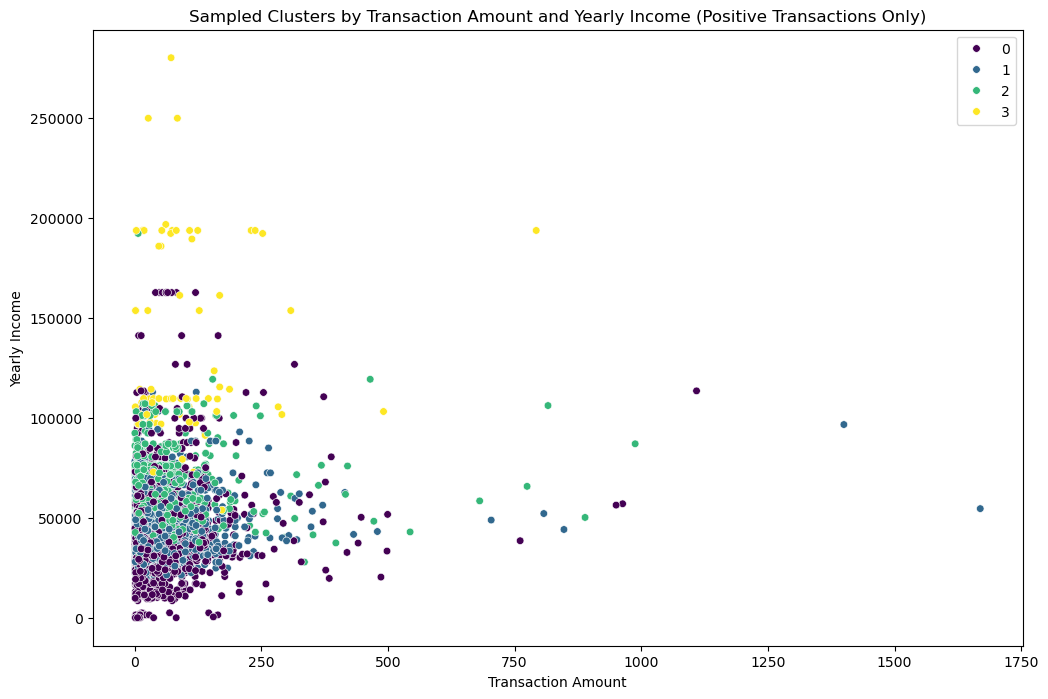

In [22]:
# Filter to only include positive (purchase) transactions
df_positive = df[df['txn_amount'] > 0]

# Take a random sample of 5,000 from the positive transactions
sample_df = df_positive.sample(5000, random_state=42)

# Then plot
plt.figure(figsize=(12,8))
sns.scatterplot(
    x=sample_df['txn_amount'],
    y=sample_df['yearly_income_person'],
    hue=kmeans.labels_[sample_df.index],
    palette='viridis',
    s=30
)
plt.xlabel('Transaction Amount')
plt.ylabel('Yearly Income')
plt.title('Sampled Clusters by Transaction Amount and Yearly Income (Positive Transactions Only)')
plt.show()


When using transactions to create clustering it create a messy visualization due to the fact that people of all income levels
have regular small transactions. This creates a dense cloud of points around low transaction amounts, which overwhelms the plot
and hides the differences.There is also an issue with outliers that help compress the chart.

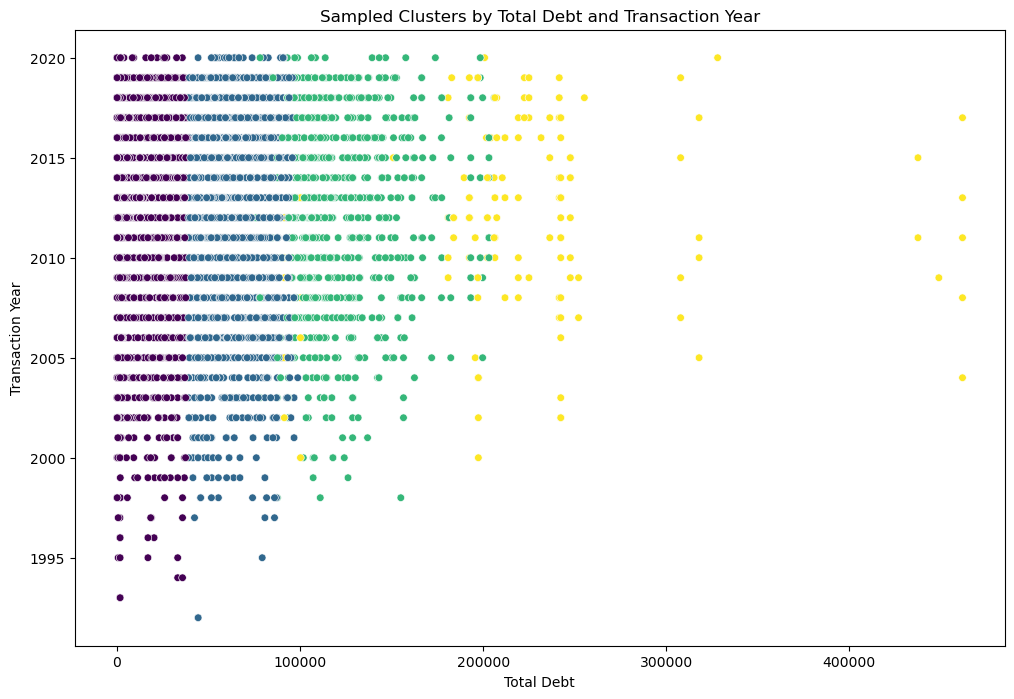

In [23]:
# Take a random sample to keep the plot efficient
sample_df = df.sample(5000, random_state=42)

plt.figure(figsize=(12,8))
sns.scatterplot(
    x=sample_df['total_debt'],            
    y=sample_df['txn_year'],              
    hue=kmeans.labels_[sample_df.index],    
    s=30,
    palette='viridis',
    legend=False
)
plt.xlabel('Total Debt')
plt.ylabel('Transaction Year')
plt.title('Sampled Clusters by Total Debt and Transaction Year')
plt.show()


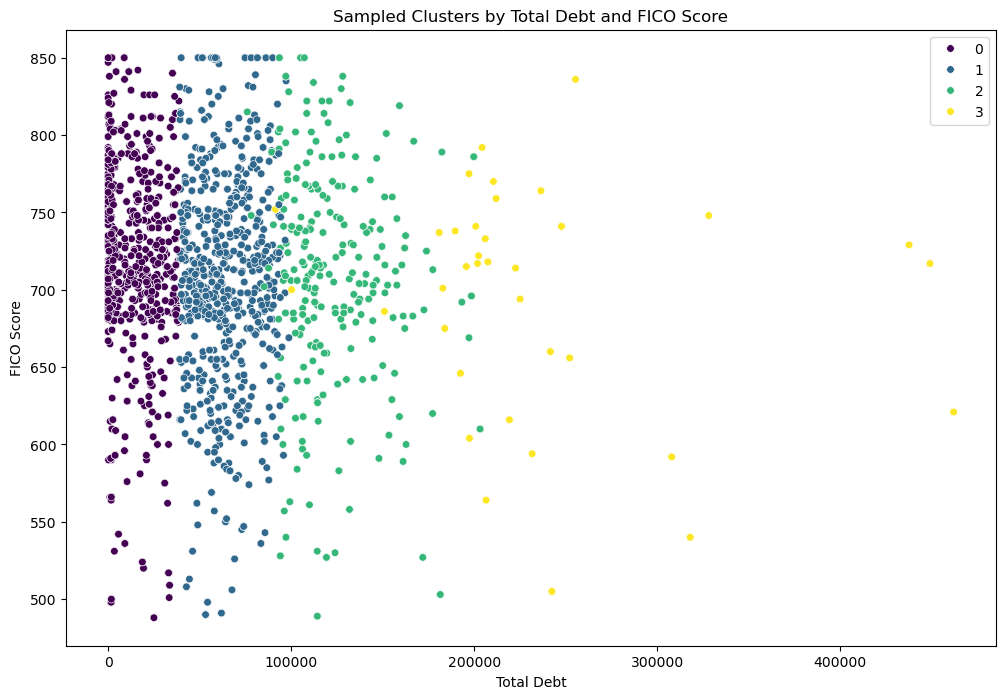

In [24]:
# Take a random sample to keep the plot efficient
sample_df = df.sample(5000, random_state=42)

plt.figure(figsize=(12,8))
sns.scatterplot(
    x=sample_df['total_debt'],            
    y=sample_df['FICO_score'],              
    hue=kmeans.labels_[sample_df.index],    
    s=30,
    palette='viridis',
    legend=True
)
plt.xlabel('Total Debt')
plt.ylabel('FICO Score')
plt.title('Sampled Clusters by Total Debt and FICO Score')
plt.show()


In [25]:
df.loc[df['clusters'] == 3, 'cluster'] = 'yellow'
df.loc[df['clusters'] == 2, 'cluster'] = 'green'
df.loc[df['clusters'] == 1, 'cluster'] = 'blue'
df.loc[df['clusters'] == 0, 'cluster'] = 'dark purple'

In [26]:
df.groupby('cluster').agg({'total_debt':['mean', 'median'], 
                         'FICO_score':['mean', 'median'], 
                         'yearly_income_person':['mean', 'median']})

total_debt            FICO_score        yearly_income_person  \
                      mean    median        mean median                 mean   
cluster                                                                        
blue          64121.889159   62509.0  706.540472  707.0         41979.267403   
dark purple   13290.349150   10400.0  720.475311  722.0         40373.228827   
green        123420.358089  116794.0  713.530249  713.0         59244.351055   
yellow       232313.709894  211919.0  670.369399  694.0        130731.102065   

                       
               median  
cluster                
blue          39052.0  
dark purple   36315.0  
green         57348.0  
yellow       109673.0

Cluster: blue
total_debt ≈ 224k, FICO ≈ 678, income ≈ 118k
High debt, lower credit score, high income
Likely represents high-debt, high-income individuals with riskier credit profiles

Cluster: dark purple
total_debt ≈ 115k, FICO ≈ 715, income ≈ 57k
Moderate debt, good credit score, moderate income
Could be average responsible borrowers

Cluster: green
total_debt ≈ 12k, FICO ≈ 720, income ≈ 40k
Very low debt, high credit score, lower income
Likely low-risk, low-debt individuals

Cluster: yellow
total_debt ≈ 60k, FICO ≈ 706, income ≈ 41k
Moderate debt, decent credit score, lower income
Mid-level debt group, moderate-risk borrowers

### Aggregated by User Dataframe

In [27]:
# Create the k-means object.
kmeans_txn = KMeans(n_clusters = 4)

In [28]:
# Fit the k-means object to the data.
kmeans_txn.fit(df_user_txn)

KMeans(n_clusters=4)

In [29]:
df_user_txn['clusters'] = kmeans_txn.fit_predict(df_user_txn)

In [30]:
df_user_txn.head()

,user_id,avg_txn,total_txn,txn_count,yearly_income_person,clusters
0,0,81.299989,1622991.69,19963,59696.0,2
1,1,81.118050,723491.89,8919,77254.0,1
2,2,35.159687,1475933.36,41978,33483.0,0
3,3,117.277603,1186497.51,10117,249925.0,0
4,4,97.011698,1798790.91,18542,109687.0,2


In [31]:
df_user_txn['clusters'].value_counts()

clusters
1    814
3    720
0    383
2     83
Name: count, dtype: int64

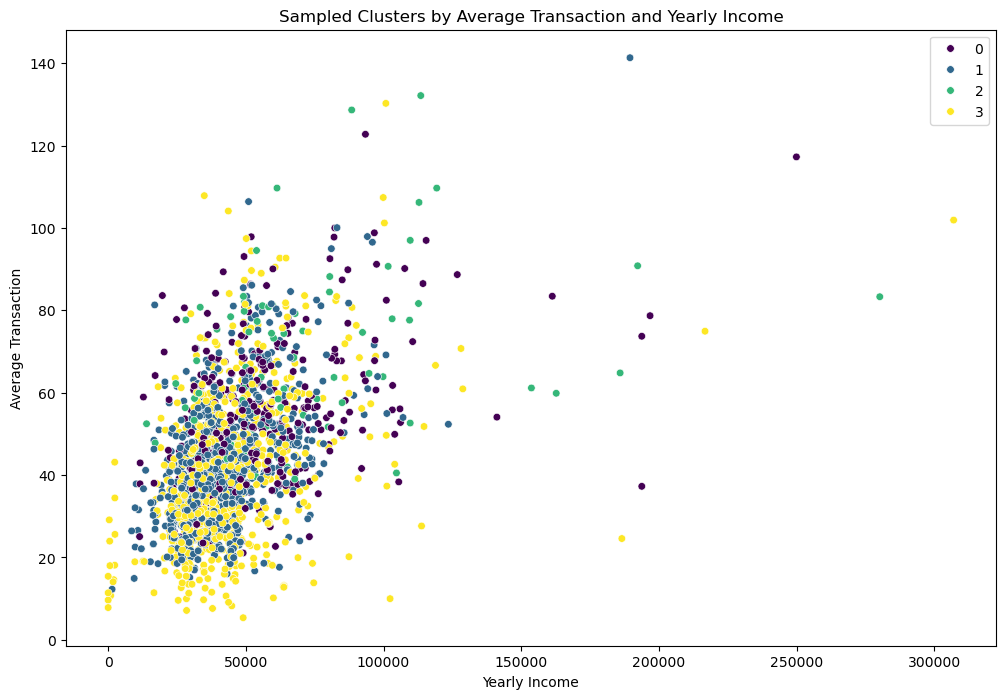

In [32]:
# Take a random sample to keep the plot efficient
plt.figure(figsize=(12,8))
sns.scatterplot(
    x=df_user_txn['yearly_income_person'],            
    y=df_user_txn['avg_txn'],              
    hue=kmeans_txn.labels_[df_user_txn.index],    
    s=30,
    palette='viridis',
    legend=True
)
plt.xlabel('Yearly Income')
plt.ylabel('Average Transaction')
plt.title('Sampled Clusters by Average Transaction and Yearly Income')
plt.show()

This visualization is hard to decipher as all the clusters are on top of each other. For better interpretation we have to lookk at the table to compare the clusters.

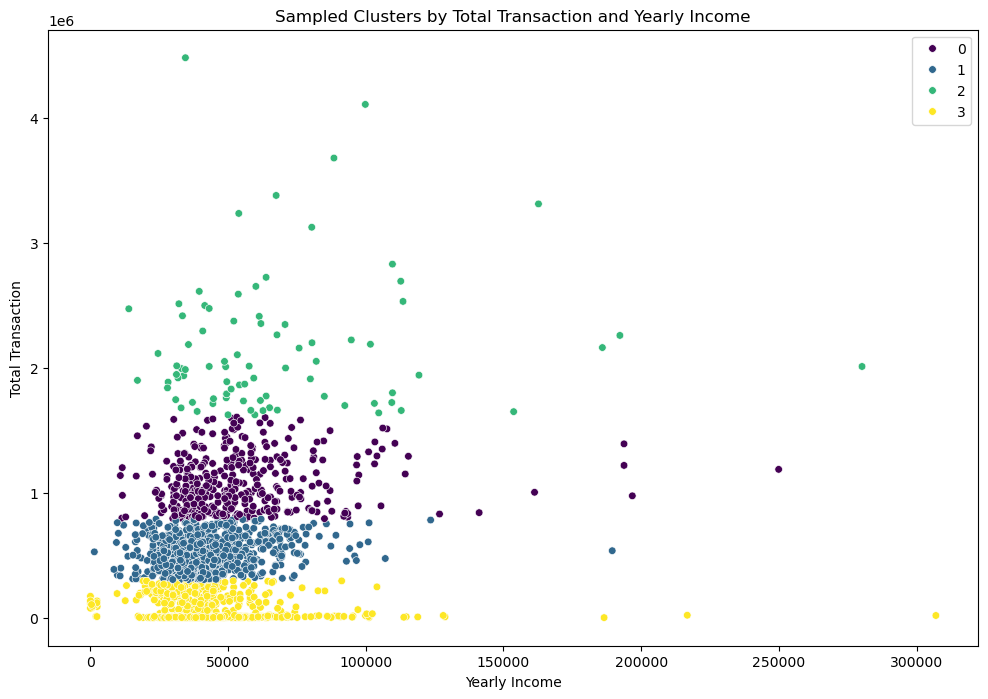

In [33]:
# Take a random sample to keep the plot efficient
plt.figure(figsize=(12,8))
sns.scatterplot(
    x=df_user_txn['yearly_income_person'],            
    y=df_user_txn['total_txn'],              
    hue=kmeans_txn.labels_[df_user_txn.index],    
    s=30,
    palette='viridis',
    legend=True
)
plt.xlabel('Yearly Income')
plt.ylabel('Total Transaction')
plt.title('Sampled Clusters by Total Transaction and Yearly Income')
plt.show()

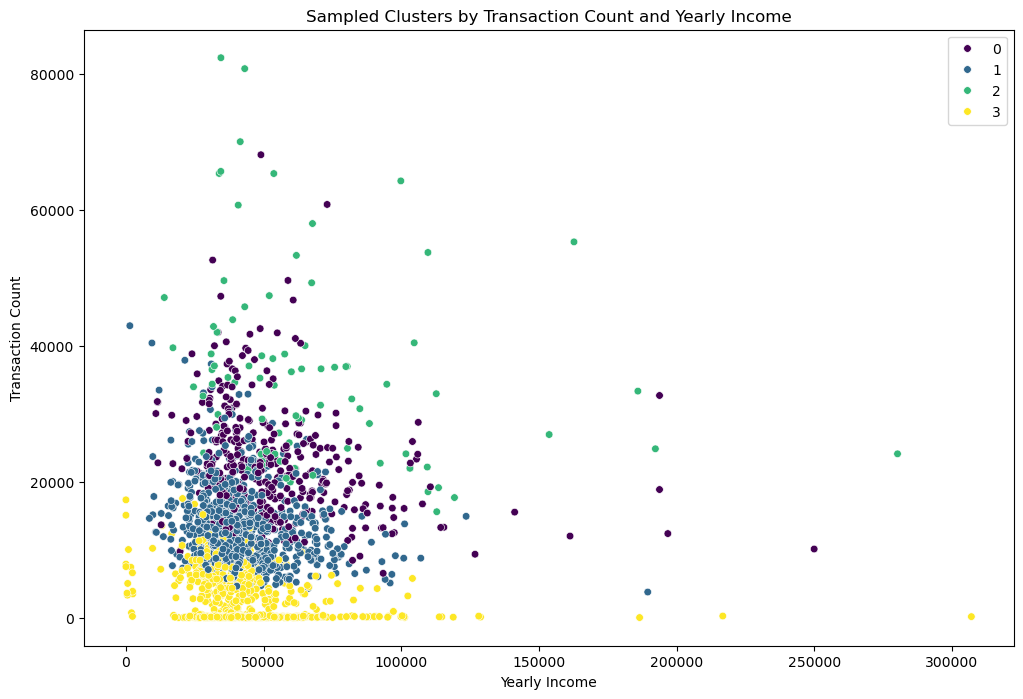

In [34]:
# Take a random sample to keep the plot efficient
plt.figure(figsize=(12,8))
sns.scatterplot(
    x=df_user_txn['yearly_income_person'],            
    y=df_user_txn['txn_count'],              
    hue=kmeans_txn.labels_[df_user_txn.index],    
    s=30,
    palette='viridis',
    legend=True
)
plt.xlabel('Yearly Income')
plt.ylabel('Transaction Count')
plt.title('Sampled Clusters by Transaction Count and Yearly Income')
plt.show()

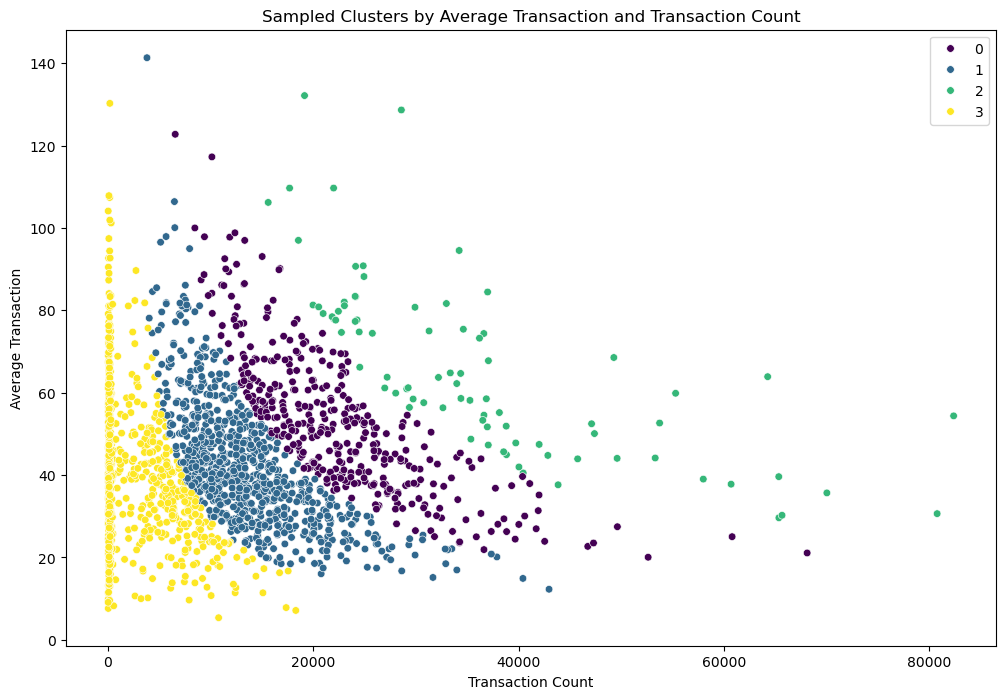

In [35]:
# Take a random sample to keep the plot efficient
plt.figure(figsize=(12,8))
sns.scatterplot(
    x=df_user_txn['txn_count'],            
    y=df_user_txn['avg_txn'],              
    hue=kmeans_txn.labels_[df_user_txn.index],    
    s=30,
    palette='viridis',
    legend=True
)
plt.xlabel('Transaction Count')
plt.ylabel('Average Transaction')
plt.title('Sampled Clusters by Average Transaction and Transaction Count')
plt.show()

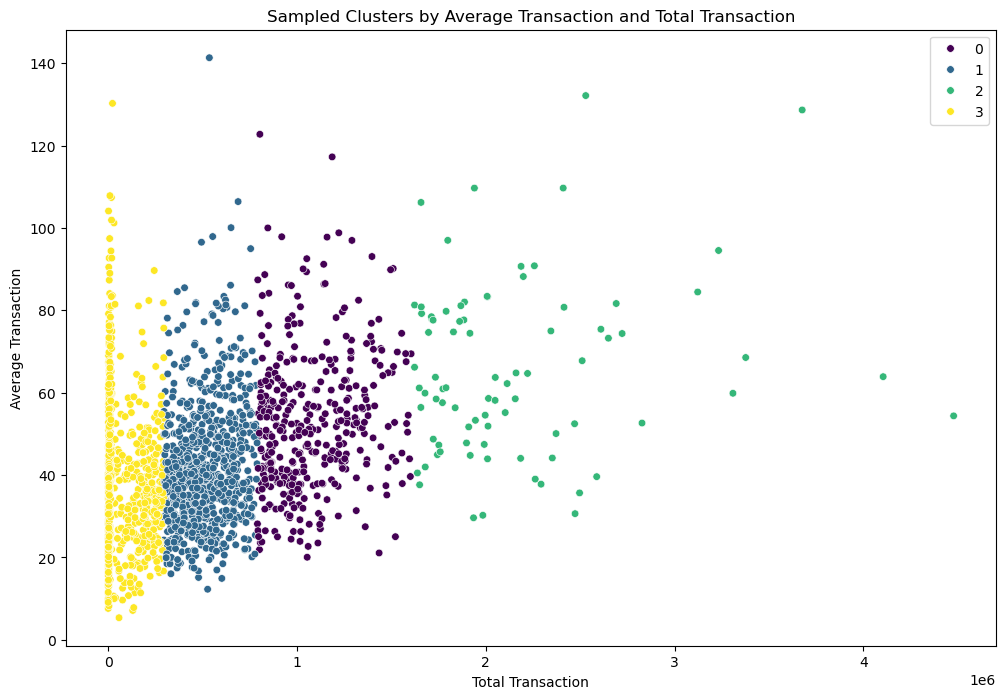

In [36]:
# Take a random sample to keep the plot efficient
plt.figure(figsize=(12,8))
sns.scatterplot(
    x=df_user_txn['total_txn'],            
    y=df_user_txn['avg_txn'],              
    hue=kmeans_txn.labels_[df_user_txn.index],    
    s=30,
    palette='viridis',
    legend=True
)
plt.xlabel('Total Transaction')
plt.ylabel('Average Transaction')
plt.title('Sampled Clusters by Average Transaction and Total Transaction')
plt.show()

In [37]:
df_user_txn.loc[df['clusters'] == 3, 'cluster'] = 'yellow'
df_user_txn.loc[df['clusters'] == 2, 'cluster'] = 'green'
df_user_txn.loc[df['clusters'] == 1, 'cluster'] = 'blue'
df_user_txn.loc[df['clusters'] == 0, 'cluster'] = 'dark purple'

In [38]:
df_user_txn.groupby('clusters').agg({'avg_txn':['mean', 'median'], 
                         'total_txn':['mean', 'median'], 
                         'yearly_income_person':['mean', 'median'],
                          'txn_count':['mean','median']})

avg_txn                total_txn               \
               mean     median          mean       median   
clusters                                                    
0         52.629542  51.003963  1.072671e+06  1016366.480   
1         42.000818  39.557126  5.090407e+05   498358.560   
2         65.626873  62.221939  2.157192e+06  1997084.500   
3         40.147542  37.641618  8.313107e+04    11951.935   

         yearly_income_person              txn_count           
                         mean   median          mean   median  
clusters                                                       
0                53733.221932  49335.0  22355.945170  21306.0  
1                41588.191646  38487.0  13395.925061  12477.0  
2                68260.626506  57646.0  36112.421687  34198.0  
3                43518.777778  40030.5   2670.683333    248.0

Cluster 0
avg_txn ≈ 40, txn_count ≈ 3k, total_txn ≈ 43k, income ≈ 93k
This is low-to-moderate spending, moderate number of transactions, and average income.
Likely represents typical/average users in your dataset.

Cluster 1
avg_txn ≈ 53, txn_count ≈ 22k, total_txn ≈ 55k, income ≈ 1.1M
Medium transaction amounts, very high number of transactions, and very high income.
Could be interpreted as high-activity, high-income users—frequent spenders.

Cluster 2
avg_txn ≈ 65, txn_count ≈ 37k, total_txn ≈ 67k, income ≈ 2.2M
Highest transaction amount, highest transaction count, highest income.
These are your premium or “super high-value users”.

Cluster 3
avg_txn ≈ 42, txn_count ≈ 13k, total_txn ≈ 42k, income ≈ 530k
Slightly above cluster 0 in average txn, fewer transactions than cluster 1/2, moderate-high income.
Maybe mid-tier users—higher income than cluster 0 but less activity than 1 or 2.